# Introduction to Time Series Analysis

-----

In this notebook, we introduce simple time series analysis. We will generate an ARMA model from the air quality data analyzed previously, and compare the forecast to actual data.

-----


## Table of Contents


[Data](#Data)


[Seasonal Decomposition](#Seasonal-Decomposition)


[ARMA Modeling](#ARMA-Modeling)


-----

Before proceeding with the rest of this notebook, we first include the notebook setup code.

-----

In [ ]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# These two lines suppress warnings that sometimes
# occur when making visualizations
import warnings
warnings.filterwarnings('ignore')

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

from datetime import datetime

-----

[[Back to TOC]](#Table-of-Contents)

## Data

To demonstrate predictive analytics on time series data, we obtain the Beijing airport environment data. Once the data is available locally, we load the data into a DataFrame, and as described in a previous lesson, we generate a time stamp index and drop unnecessary columns.

-----




In [2]:
# Beijing PM2.5 Data Data Set from UCI ML Repository
# https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv

# First we find our HOME directory
tmp = !echo $HOME

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/data/PRSA_data_2010.1.1-2014.12.31.csv'

In [3]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv
else
    
    echo "File already exists locally."
fi

File already exists locally.


In [4]:
# Load local data file
df = pd.read_csv(data_file, index_col=False)

In [3]:
data_file='https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
df = pd.read_csv(data_file, index_col=False)

In [3]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [6]:
df.sample(5)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
43769,43770,2014,12,29,17,22.0,-15,10.0,1012.0,NW,36.65,0,0
32031,32032,2013,8,27,15,67.0,20,26.0,1006.0,SE,1.79,0,0
3177,3178,2010,5,13,9,83.0,7,19.0,1020.0,SE,5.37,0,0
28207,28208,2013,3,21,7,107.0,-3,0.0,1013.0,cv,0.89,0,0
16720,16721,2011,11,28,16,143.0,0,7.0,1027.0,SE,19.67,0,0


In [4]:
df['TS'] = pd.to_datetime(df.apply(lambda x:
                                   datetime(x.year, x.month, x.day, x.hour),
                                   axis=1))

In [5]:
df.index = pd.DatetimeIndex(df.TS)

In [6]:
# Remove extra columns
df.drop(['year', 'month', 'day', 'hour', 'TS'], axis=1, inplace=True)

In [8]:
df.sort_index(inplace=True)

In [10]:
df.head(5)

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
TS,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


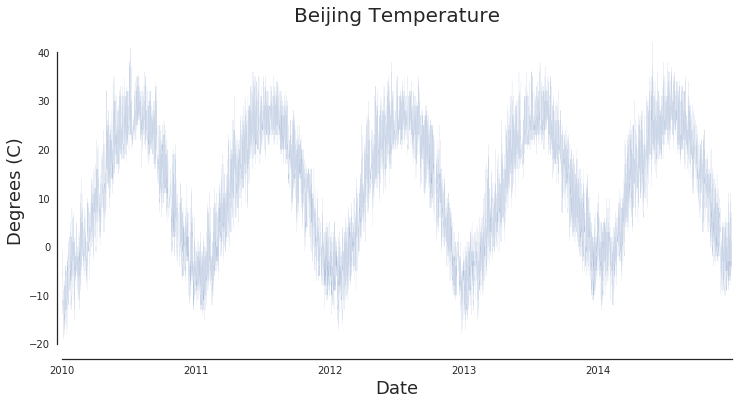

In [8]:
# Plot Temperature 
fig, ax = plt.subplots(figsize=(12, 6))

df.TEMP.plot(lw=0.1, alpha=0.5)

ax.set(title='Beijing Temperature',
      xlabel='Date', ylabel = 'Degrees (C)')

sns.despine(offset=5, trim=True)

-----

## Seasonal Decomposition

We can perform automatic seasonal decomposition on a time series data set by using the statsmodels library. We demonstrate this in the following Code cells, where we first create a four year, daily date range, and performa a seasonal decomposition on these data. We plot one year's data in the different seasonal, trend, and residual to verify the efficacy of the decomposition.

-----

In [21]:
seasonal_decompose?

In [11]:
rng = pd.date_range('2010-01-01 00', '2014-12-31 00', freq='D')

dt1 = df['TEMP'][rng]

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dt1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

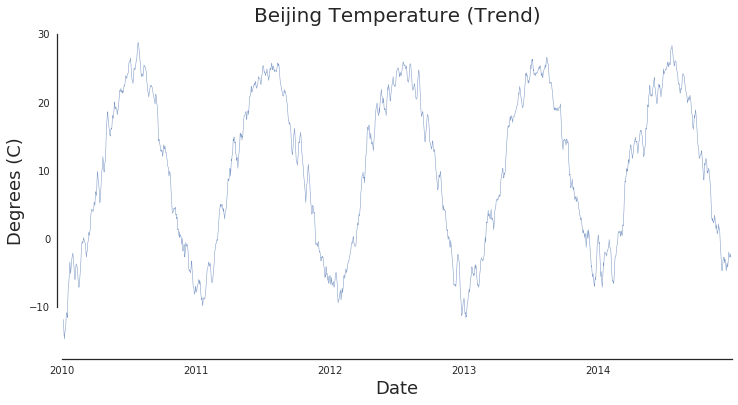

In [14]:
# Plot one year's temperature data
fig, ax = plt.subplots(figsize=(12, 6))

trend.plot(lw=0.5, alpha=0.75)

ax.set(title='Beijing Temperature (Trend)',
      xlabel='Date', ylabel = 'Degrees (C)')

sns.despine(offset=5, trim=True)

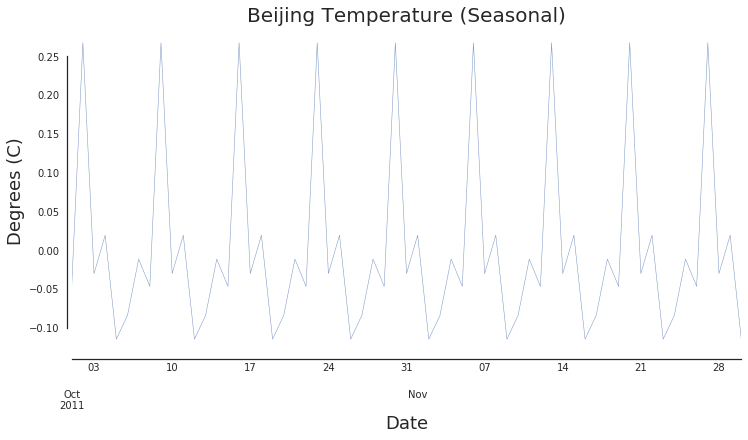

In [15]:
# Plot one month's temperature data
fig, ax = plt.subplots(figsize=(12, 6))

seasonal['2011-10': '2011-11'].plot(lw=0.5, alpha=0.75)

ax.set(title='Beijing Temperature (Seasonal)',
      xlabel='Date', ylabel = 'Degrees (C)')

sns.despine(offset=5, trim=True)

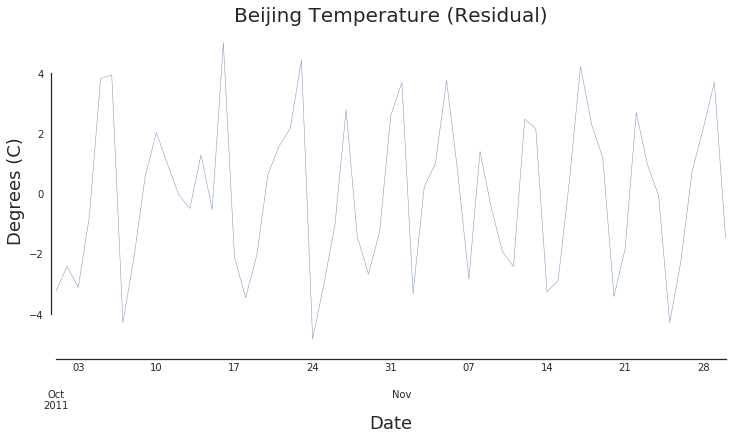

In [16]:
# Plot one month's temperature data
fig, ax = plt.subplots(figsize=(12, 6))

residual['2011-10': '2011-11'].plot(lw=0.5, alpha=0.75)

ax.set(title='Beijing Temperature (Residual)',
      xlabel='Date', ylabel = 'Degrees (C)')

sns.despine(offset=5, trim=True)

-----

## ARMA modeling

To make forecasts, we need to model the time series data. One of the simplest models is the ARMA model. In the following Code cells, we perform an ARMA model, following the guidance of the statsmodels documentation. This includes computing the autocorrelation of the time series data, performing the ARMA model fit (by using information obtained from the correlation plots), and displaying the model fit results.

-----

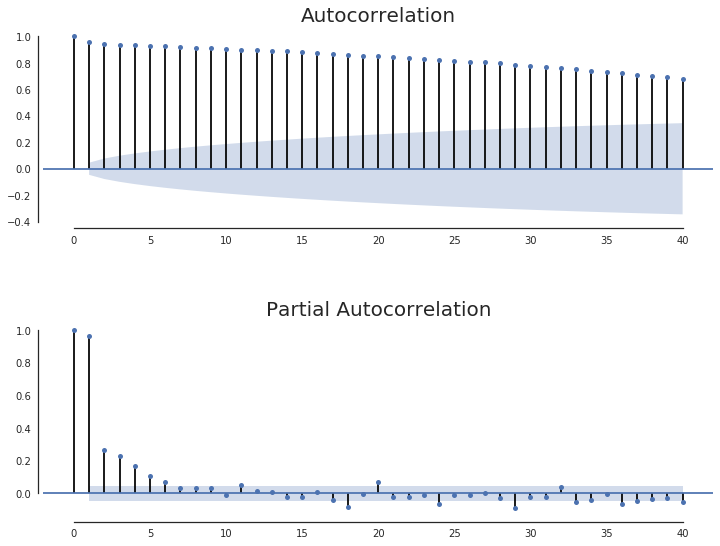

In [17]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,9))
fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(211)
_ = sm.graphics.tsa.plot_acf(dt1.values.squeeze(), lags=40, ax=ax1)
sns.despine(offset=5, trim=True, ax=ax1)

ax2 = fig.add_subplot(212)
_ = sm.graphics.tsa.plot_pacf(dt1.values, lags=40, ax=ax2)
sns.despine(offset=5, trim=True, ax=ax2)

In [18]:
arma_model = sm.tsa.ARMA(dt1, (7, 1))
arma_res = arma_model.fit(trend='c', disp=True)

In [19]:
print(arma_res.summary())

                              ARMA Model Results                              
Dep. Variable:                   TEMP   No. Observations:                 1826
Model:                     ARMA(7, 1)   Log Likelihood               -4501.002
Method:                       css-mle   S.D. of innovations              2.844
Date:                Tue, 28 Nov 2017   AIC                           9022.003
Time:                        19:35:57   BIC                           9077.102
Sample:                    01-01-2010   HQIC                          9042.328
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0174      6.300      0.955      0.340      -6.330      18.365
ar.L1.TEMP     1.2316      0.092     13.427      0.000       1.052       1.411
ar.L2.TEMP    -0.3245      0.061     -5.294      0.0

In [20]:
print(arma_res.params)

const         6.017436
ar.L1.TEMP    1.231560
ar.L2.TEMP   -0.324502
ar.L3.TEMP    0.049567
ar.L4.TEMP    0.030713
ar.L5.TEMP    0.001428
ar.L6.TEMP    0.010170
ar.L7.TEMP   -0.001976
ma.L1.TEMP   -0.682503
dtype: float64


-----

Below, we plot our model residuals, which look reasonable.

-----

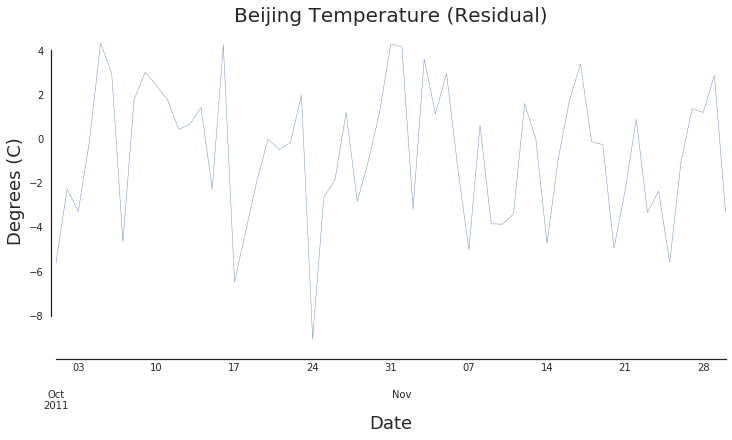

In [21]:
# Plot one year's temperature data
fig, ax = plt.subplots(figsize=(12, 6))

arma_res.resid['2011-10': '2011-11'].plot(lw=0.5, alpha=0.75)

ax.set(title='Beijing Temperature (Residual)',
      xlabel='Date', ylabel = 'Degrees (C)')

sns.despine(offset=5, trim=True)

-----

We can create a QQ plot to determine how well our model fits the data.In this case, we see that there are deviations at both ends, basically outside the middle fifty percent of the data. This suggests the fit misses the peaks and valleys in our data set and focuses more on the middle range (which is not a good result).

-----

In [22]:
from scipy import stats

resid = arma_res.resid
stats.normaltest(resid)

NormaltestResult(statistic=40.424942906549624, pvalue=1.6666146006559593e-09)

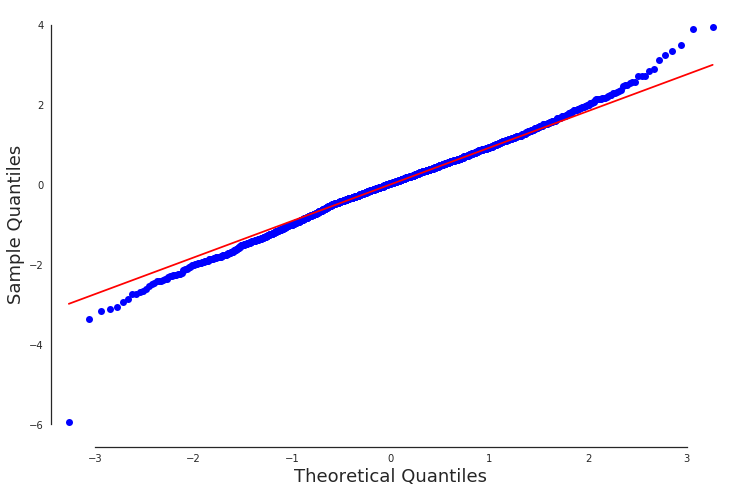

In [23]:
from statsmodels.graphics.api import qqplot

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
_ = qqplot(resid, line='q', ax=ax, fit=True)

sns.despine(offset=5, trim=True)

-----

We can create autocorrelation plots from our model residuals. In this case we see very little structure.

-----

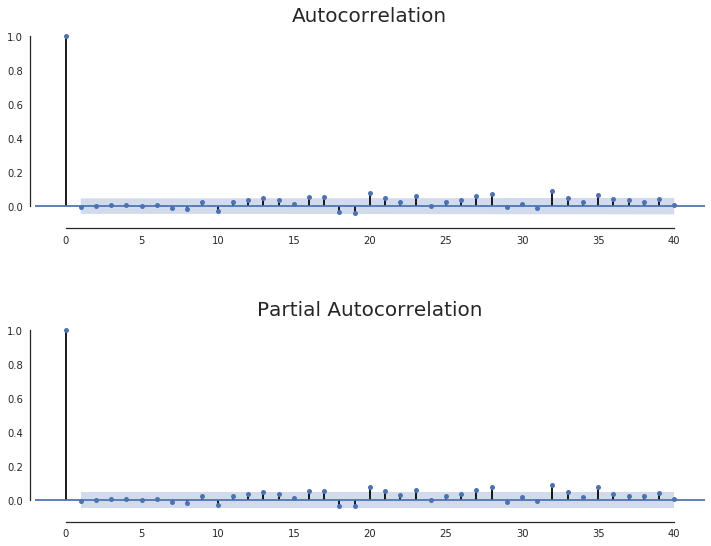

In [24]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,9))
fig.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(211)
_ = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
sns.despine(offset=5, trim=True, ax=ax1)

ax2 = fig.add_subplot(212)
_ = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
sns.despine(offset=5, trim=True, ax=ax2)

-----

Finally, we can generate a visualization that compares the data to our model forecast (along with the confidence intervals). In this case, we see that our model (as expected) misses the large features, or peaks and valleys. With a more complex model, we likely would achieve better performance.

-----

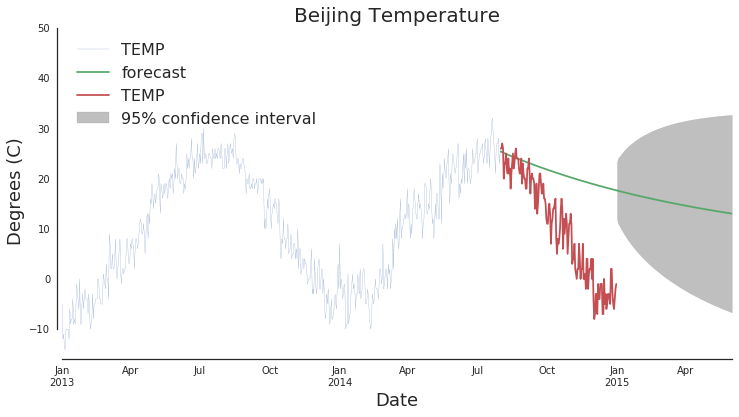

In [25]:
# Plot one year's temperature data
fig, ax = plt.subplots(figsize=(12, 6))

ax = dt1['2013':].plot(ax=ax, alpha=0.7, lw=0.25)
fig = arma_res.plot_predict('2014-08', '2015-06', dynamic=True, ax=ax, plot_insample=True)

ax.set(title='Beijing Temperature',
      xlabel='Date', ylabel = 'Degrees (C)', ylim=(-15, 50))

sns.despine(offset=5, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>


In the preceding cells, we introduced time series analysis to make a predictive model for  time series data. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Change the feature from Temperature to a different value. Does the fit improve? Why or why not?
3. Note, we applied the ARMA model to the original temperature dat, which is not stationary. Difference the data to make a new feature, and apply the ARMA model to these new data. Does the fit improve? Why or Why not?
1. Change the predictive model to ARIMA, do you get improved results?
2. Try using a a GARCH model, do you get improved results?

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

12. Wikipedia article on [forecasting][wf]
1. Introduction to machine learning for [time series forecasting][tsfpq] in Python
3. [Time series forecasting][tsfp] in Python
3. Python based [time series analysis][ptsa] article
4. Python based article on [ARIMA models][pam]
4. Python based article on [SARIMA models][psam]
4. Python based article on [ARIMAX models][paxm]
4. Python based article on [GARCH models][pgm]
5. Article on [time series forecasting][bapts] using Python
6. Multipart article on time series forecasting using R, [Part I][p1r], [Part II][p2r], and [Part III][p3r]

7. Introduction to [time series analysis][tsrb] using R
8. Business [time series forecasting][btsf] text
9. First course on [time series analysis][ctsa] text using SAS
10. Online course material for [time series analysis][psuts] from Penn State University
10. Online course material for [time series analysis][ucbts] from University of California, Berkeley
11. Cheatsheet on what [forecasting model to use and why][dwuts]
11. Cheatsheet on [summary rules for ARIMA models][srts]
12. Notebook demonstrating how to apply [time series analysis][ntsg] in Python
13. (older) presentation by creator of Pandas on [time series modeling][tsm] in Python

-----

[wf]: https://en.wikipedia.org/wiki/Forecasting

[tsfp]: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
[ptsa]: https://bicorner.com/2015/11/16/time-series-analysis-using-ipython/
[pam]: http://barnesanalytics.com/basics-of-arima-models-with-statsmodels-in-python
[psam]: http://barnesanalytics.com/sarima-models-using-statsmodels-in-python
[paxm]: http://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels
[pgm]: http://barnesanalytics.com/garch-models-in-python
[bapts]: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
[p1r]: https://www.quantstart.com/articles/ARIMA-GARCH-Trading-Strategy-on-the-SP500-Stock-Market-Index-Using-R
[p2r]: https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-2
[p3r]: https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-3
[tsrb]: http://www.stat.pitt.edu/stoffer/tsa4/tsaEZ.pdf
[btsf]: http://home.ubalt.edu/ntsbarsh/Business-stat/stat-data/Forecast.htm
[ctsa]: http://www.statistik-mathematik.uni-wuerzburg.de/fileadmin/10040800/user_upload/time_series/the_book/2012-August-01-times.pdf
[psuts]: https://onlinecourses.science.psu.edu/stat510/node/47
[ucbts]: https://www.stat.berkeley.edu/~bartlett/courses/153-fall2010/lectures/1.

[dwuts]: http://people.duke.edu/~rnau/whatuse.htm
[srts]: http://people.duke.edu/~rnau/arimrule.htm
[ntsg]: https://github.com/twiecki/financial-analysis-python-tutorial/blob/master/2.%20Pandas%20replication%20of%20Google%20Trends%20paper.ipynb
[tsm]: http://conference.scipy.org/scipy2011/slides/mckinney_time_series.pdf
[tsfpq]: https://www.quantstart.com/articles/Forecasting-Financial-Time-Series-Part-1

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode